In [0]:
import os ; os.chdir('/content/drive/My Drive/Colab Notebooks/Project- Loan Prediction')

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

#import classes for imputation
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# import extra classes for modelling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV

In [0]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [72]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [0]:
cols = list(data.columns)

In [74]:
cols

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area',
 'Loan_Status']

In [75]:
#inspect data types
data.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [76]:
#inspect the variable values

for var in data.columns:
    print(var, data[var].unique()[0:20], '\n')

Loan_ID ['LP001002' 'LP001003' 'LP001005' 'LP001006' 'LP001008' 'LP001011'
 'LP001013' 'LP001014' 'LP001018' 'LP001020' 'LP001024' 'LP001027'
 'LP001028' 'LP001029' 'LP001030' 'LP001032' 'LP001034' 'LP001036'
 'LP001038' 'LP001041'] 

Gender ['Male' 'Female' nan] 

Married ['No' 'Yes' nan] 

Dependents ['0' '1' '2' '3+' nan] 

Education ['Graduate' 'Not Graduate'] 

Self_Employed ['No' 'Yes' nan] 

ApplicantIncome [ 5849  4583  3000  2583  6000  5417  2333  3036  4006 12841  3200  2500
  3073  1853  1299  4950  3596  3510  4887  2600] 

CoapplicantIncome [    0.  1508.  2358.  4196.  1516.  2504.  1526. 10968.   700.  1840.
  8106.  2840.  1086.  3500.  5625.  1911.  1917.  2925.  2253.  1040.] 

LoanAmount [ nan 128.  66. 120. 141. 267.  95. 158. 168. 349.  70. 109. 200. 114.
  17. 125. 100.  76. 133. 115.] 

Loan_Amount_Term [360. 120. 240.  nan 180.  60. 300. 480.  36.  84.  12.] 

Credit_History [ 1.  0. nan] 

Property_Area ['Urban' 'Rural' 'Semiurban'] 

Loan_Status ['Y' 'N'] 



There are continuous and discrete variables.

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [0]:
#data['Credit_History'] = data['Credit_History'].astype()

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [0]:
data = data.drop('Loan_ID', axis=1)

In [81]:
data.shape

(614, 12)

In [0]:
#make a list of variable types

#numerical: discrete bvs continuous
discrete = [var for var in data.columns if data[var].dtype != 'O' and var != 'Loan_Status' and data[var].nunique()<10]
continuous = [var for var in data.columns if data[var].dtype != 'O' and var != 'Loan_Status' and var not in discrete]
#categorical
categorical = [var for var in data.columns if data[var].dtype == 'O' and var != 'Loan_Status']

In [83]:
discrete

['Credit_History']

In [84]:
continuous

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

In [85]:
categorical

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area']

In [86]:
print(f'There are {len(discrete)} discrete features')
print(f'\nThere are {len(continuous)} continuous features')
print(f'\nThere are {len(categorical)} categorical features')

There are 1 discrete features

There are 4 continuous features

There are 6 categorical features


In [87]:
#Missing data

data.isnull().mean()

Gender               0.021173
Married              0.004886
Dependents           0.024430
Education            0.000000
Self_Employed        0.052117
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           0.035831
Loan_Amount_Term     0.022801
Credit_History       0.081433
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

There are missing data in our variables.

In [88]:
#check cardinality of categorical variables
data[categorical].nunique()

Gender           2
Married          2
Dependents       4
Education        2
Self_Employed    2
Property_Area    3
dtype: int64

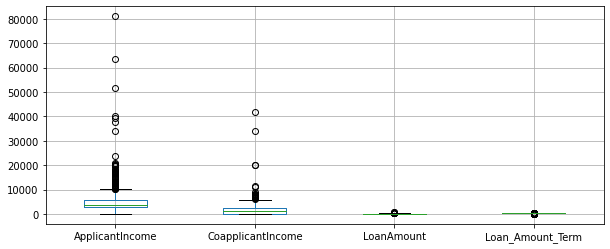

In [89]:
#outliers in continuous variables
data[continuous].boxplot(figsize=(10,4))

In [90]:
#feature magnitude
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [91]:
data['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [0]:
#Convert target column values to 0 and 1
data['Loan_Status'] = [1 if x == 'Y' else (0 if x=='N' else np.nan) for x in data['Loan_Status'] ]
#data['Loan_Status'].replace('N', 0,inplace=True) 
#data['Loan_Status'].replace('Y', 1,inplace=True)

###Train Test Split

In [93]:
'''
#Train test split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data.drop(['Loan_Status'], axis=1), #predictors
                                                data['Loan_Status'], #target
                                                stratify = data['Loan_Status'], #equal class split
                                                test_size = 0.25)
Xtrain.shape, Ytrain.shape
Xtest.shape, Ytest.shape
#train class distribution
Ytrain.value_counts()
#test class distribution
Ytest.value_counts()
#Train class distribution
for x in Ytrain.unique():
    print(f'Class {x}: {np.round(Ytrain[Ytrain==x].shape[0]/Ytrain.shape[0] * 100, 2)}%')
#Test class distribution
for x in Ytest.unique():
    print(f'Class {x}: {np.round(Ytest[Ytest==x].shape[0]/Ytest.shape[0] * 100, 2)}%')
'''

"\n#Train test split\nXtrain, Xtest, Ytrain, Ytest = train_test_split(data.drop(['Loan_Status'], axis=1), #predictors\n                                                data['Loan_Status'], #target\n                                                stratify = data['Loan_Status'], #equal class split\n                                                test_size = 0.25)\nXtrain.shape, Ytrain.shape\nXtest.shape, Ytest.shape\n#train class distribution\nYtrain.value_counts()\n#test class distribution\nYtest.value_counts()\n#Train class distribution\nfor x in Ytrain.unique():\n    print(f'Class {x}: {np.round(Ytrain[Ytrain==x].shape[0]/Ytrain.shape[0] * 100, 2)}%')\n#Test class distribution\nfor x in Ytest.unique():\n    print(f'Class {x}: {np.round(Ytest[Ytest==x].shape[0]/Ytest.shape[0] * 100, 2)}%')\n"

In [0]:
Xtrain = data.drop(['Loan_Status'], axis=1).copy()
Ytrain = data['Loan_Status'].copy()                    

##Univariate Analysis

####Target Variable

In [95]:
Ytrain.value_counts(normalize=True)

1    0.687296
0    0.312704
Name: Loan_Status, dtype: float64

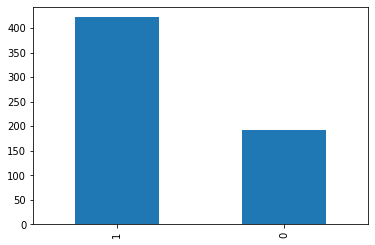

In [96]:
Ytrain.value_counts().plot.bar()

####Categorical Features

In [97]:
#Inspect variable distribution

#categorical
Xtrain.select_dtypes(include='O').describe()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area
count,601,611,599,614,582,614
unique,2,2,4,2,2,3
top,Male,Yes,0,Graduate,No,Semiurban
freq,489,398,345,480,500,233


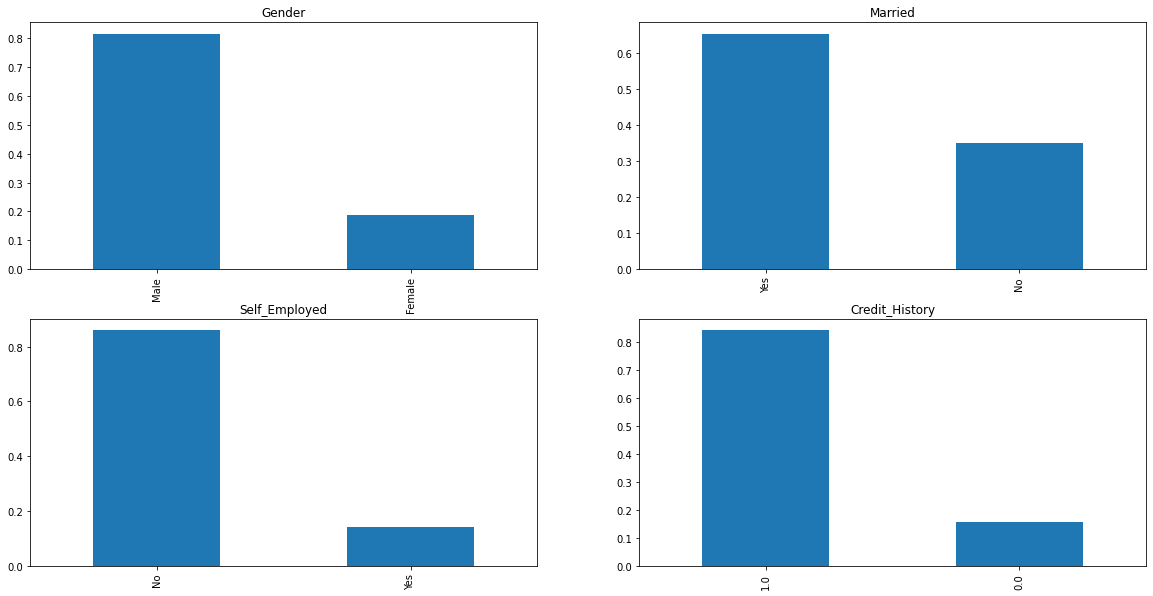

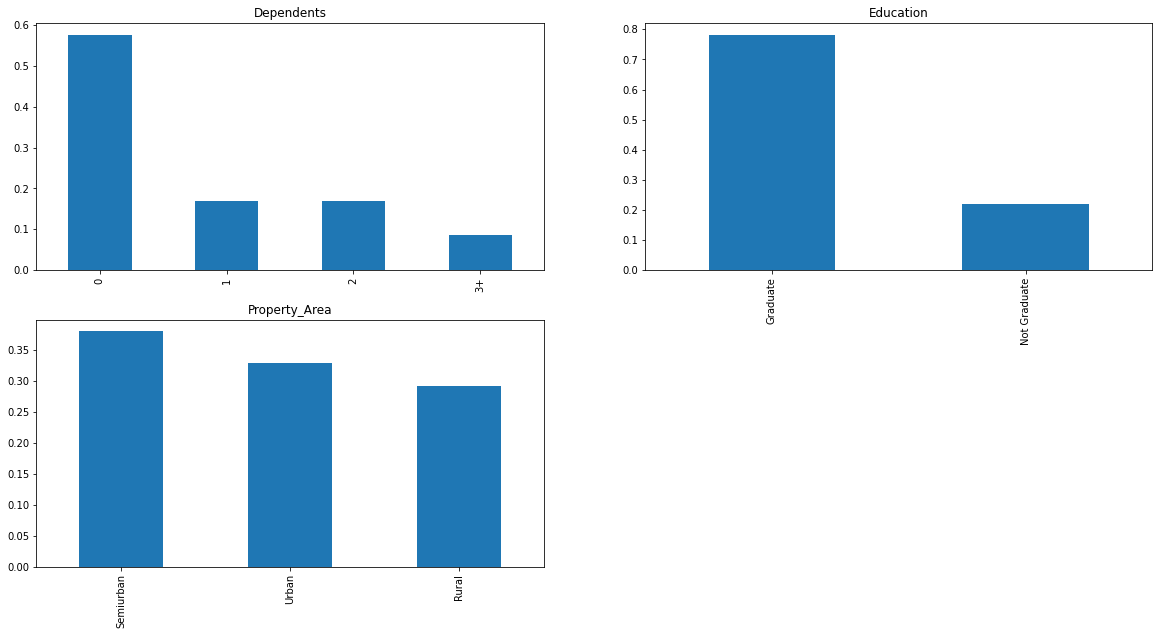

In [98]:
plt.figure(1)
plt.subplot(221)
Xtrain['Gender'].value_counts(normalize=True).plot.bar(figsize=(20,10), title='Gender')

plt.subplot(222)
Xtrain['Married'].value_counts(normalize=True).plot.bar(figsize=(20,10), title='Married')

plt.subplot(223)
Xtrain['Self_Employed'].value_counts(normalize=True).plot.bar(figsize=(20,10), title='Self_Employed')

plt.subplot(224)
Xtrain['Credit_History'].value_counts(normalize=True).plot.bar(figsize=(20,10), title='Credit_History')

plt.figure(2)

plt.subplot(221)
Xtrain['Dependents'].value_counts(normalize=True).plot.bar(figsize=(20,10), title='Dependents')

plt.subplot(222)
Xtrain['Education'].value_counts(normalize=True).plot.bar(figsize=(20,10), title='Education')

plt.subplot(223)
Xtrain['Property_Area'].value_counts(normalize=True).plot.bar(figsize=(20,10), title='Property_Area')

plt.show()

It can be inferred from the above bar plots that:

80% applicants in the dataset are male.
Around 65% of the applicants in the dataset are married.
Around 15% applicants in the dataset are self employed.
Around 85% applicants have repaid their debts.

Most of the applicants don’t have any dependents.
Around 80% of the applicants are Graduate.
Most of the applicants are from Semiurban area.

#### Numerical Features

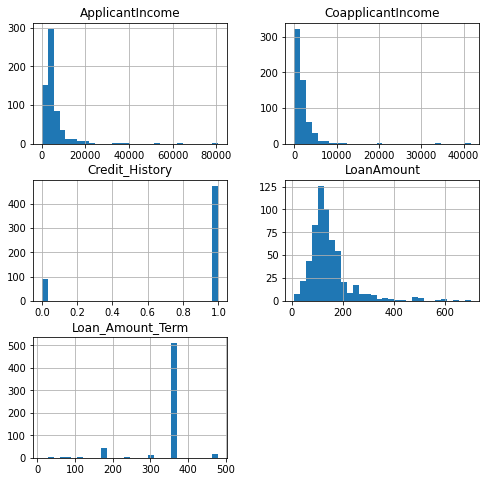

In [99]:
#Inspect variable distribution

#numerical
Xtrain.select_dtypes(exclude='O').hist(bins=30, figsize=(8,8))
plt.show()


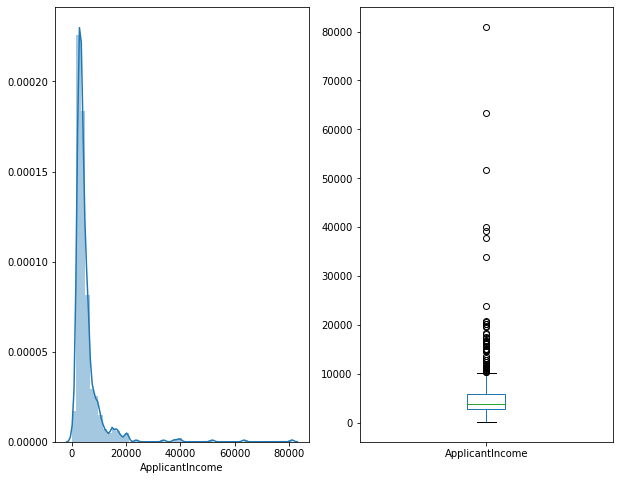

In [100]:
#ApplicantIncome
plt.figure(1)
plt.subplot(121)
sns.distplot(Xtrain['ApplicantIncome'])
plt.subplot(122)
Xtrain['ApplicantIncome'].plot.box(figsize=(10,8))
plt.show()

It can be inferred that most of the data in the distribution of applicant income is towards left which means it is not normally distributed.

The boxplot confirms the presence of a lot of outliers/extreme values. This can be attributed to the income disparity in the society. Part of this can be driven by the fact that we are looking at people with different education levels.

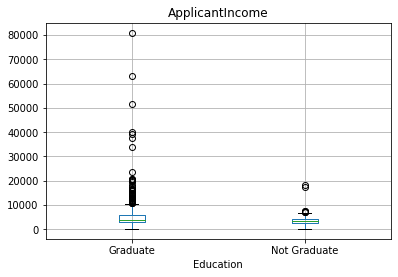

In [101]:
#Visualize Applicant income based on education
Xtrain.boxplot(column='ApplicantIncome', by='Education')
plt.suptitle("")
plt.show()

We can see that there are a higher number of graduates with very high incomes, which are appearing to be the outliers.

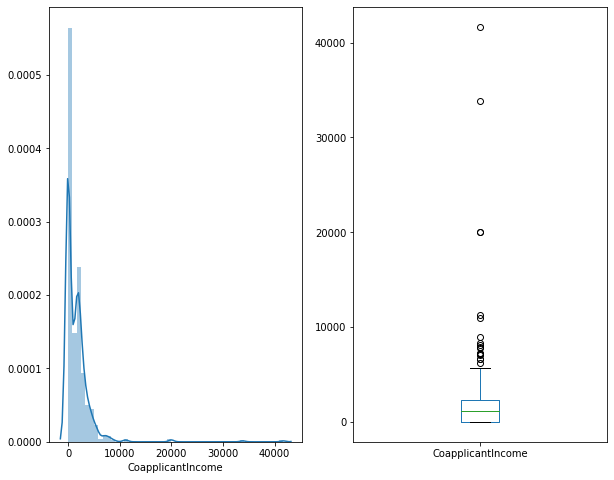

In [102]:
#CoapplicantIncome
plt.figure(1)
plt.subplot(121)
sns.distplot(Xtrain['CoapplicantIncome'])
plt.subplot(122)
Xtrain['CoapplicantIncome'].plot.box(figsize=(10,8))
plt.show()

We see a similar distribution as that of the applicant income. Majority of coapplicant’s income ranges from 0 to 5000. We also see a lot of outliers in the coapplicant income and it is not normally distributed.

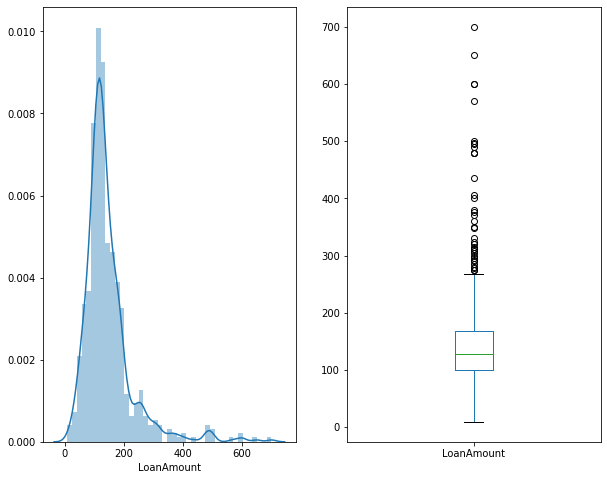

In [103]:
#Loan amount
plt.figure(1)
plt.subplot(121)
sns.distplot(Xtrain['LoanAmount'])
plt.subplot(122)
Xtrain['LoanAmount'].plot.box(figsize=(10,8))
plt.show()

We see a lot of outliers in this variable and the distribution is fairly normal.

## Bivariate Analysis

We would like to know how well each feature correlate with Loan Status.

*Categorical Variables vs Target Variable*

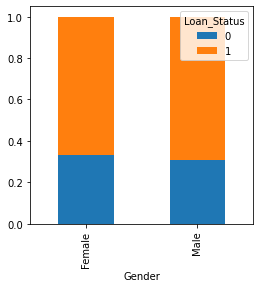

In [104]:
#Gender vs Loan status
Gender = pd.crosstab(Xtrain['Gender'], Ytrain)
Gender.div(Gender.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,4))
plt.show()

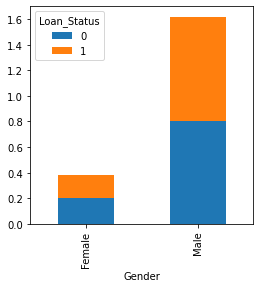

In [105]:
#Gender vs Loan status
Gender = pd.crosstab(Xtrain['Gender'], Ytrain)
Gender.div(Gender.sum(axis=0), axis=1).plot(kind='bar', stacked=True, figsize=(4,4))
plt.show()

It can be inferred that the proportion of male and female applicants is more or less same for both approved and unapproved loans.

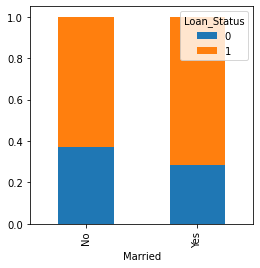

In [106]:
#Married vs Loan status
Married = pd.crosstab(Xtrain['Married'],Ytrain) 
Married.div(Married.sum(axis=1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(4,4)) 
plt.show()

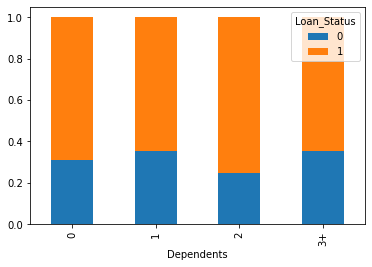

In [107]:
#Dependents vs Loan Status
Dependents=pd.crosstab(Xtrain['Dependents'],Ytrain) 
Dependents.div(Dependents.sum(axis=1).astype(float), axis=0).plot(kind="bar", stacked=True) 
plt.show() 

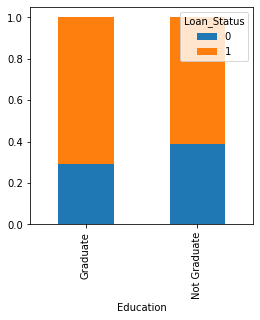

In [108]:
#Education vs Loan Status
Education = pd.crosstab(Xtrain['Education'],Ytrain) 
Education.div(Education.sum(axis=1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(4,4)) 
plt.show()

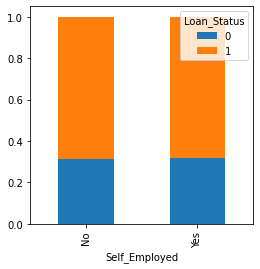

In [109]:
#Self-Employed vs Loan Status
Self_Employed=pd.crosstab(Xtrain['Self_Employed'],Ytrain)
Self_Employed.div(Self_Employed.sum(axis=1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(4,4)) 
plt.show()

Proportion of married applicants is higher for the approved loans.
Distribution of applicants with 1 or 3+ dependents is similar across both the categories of Loan_Status.
There is nothing significant we can infer from Self_Employed vs Loan_Status plot.

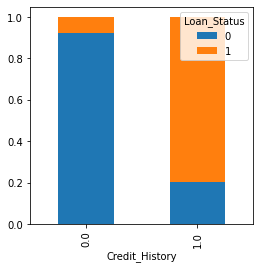

In [110]:
#Credit History
Credit_History=pd.crosstab(Xtrain['Credit_History'],Ytrain) 
Credit_History.div(Credit_History.sum(axis=1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(4,4))
plt.show()

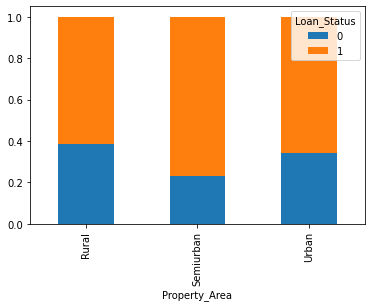

In [111]:
#Property Area vs Loan Status
Property_Area=pd.crosstab(Xtrain['Property_Area'], Ytrain)
Property_Area.div(Property_Area.sum(axis=1).astype(float), axis=0).plot(kind="bar", stacked=True)  
plt.show()

It seems people with credit history as 1 are more likely to get their loans approved.
Proportion of loans getting approved in semiurban area is higher as compared to that in rural or urban areas.

#### *Numerical Variables vs Target Variable*

Income vs Loan Status

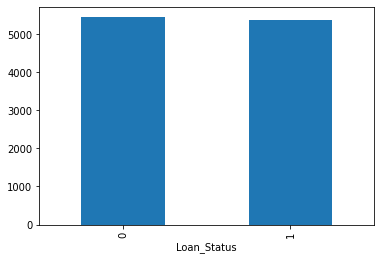

In [112]:
data.groupby('Loan_Status')['ApplicantIncome'].mean().plot.bar()
plt.show()

Here the y-axis represents the mean applicant income. We don’t see any change in the mean income.

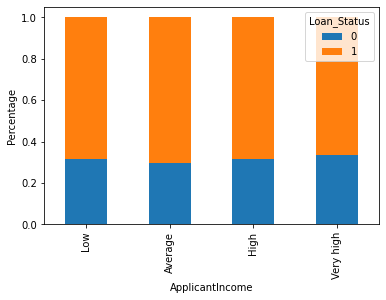

In [113]:
#let’s make bins for the applicant income variable based on the values in it and analyze the corresponding loan status for each bin.
bins=[0,2500,4000,6000,81000]
group=['Low','Average','High', 'Very high'] 
Xtrain['Income_bin'] = pd.cut(Xtrain['ApplicantIncome'], bins, labels=group)
Income_bin = pd.crosstab(Xtrain['Income_bin'], Ytrain)
Income_bin.div(Income_bin.sum(axis=1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel('ApplicantIncome')
plt.ylabel('Percentage')
plt.show()

It can be inferred that Applicant income does not affect the chances of loan approval which contradicts our hypothesis in which we assumed that if the applicant income is high the chances of loan approval will also be high.

CoApplicant vs Loan Status

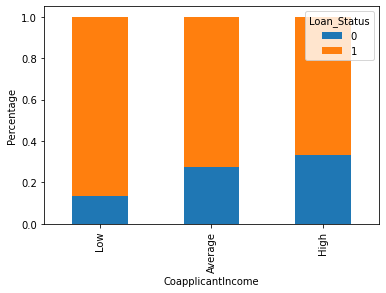

In [114]:
bins=[0,1000,3000,42000] 
group=['Low','Average','High'] 
Xtrain['Coapplicant_Income_bin']=pd.cut(Xtrain['CoapplicantIncome'],bins,labels=group)
Coapplicant_Income_bin=pd.crosstab(Xtrain['Coapplicant_Income_bin'],Ytrain) 
Coapplicant_Income_bin.div(Coapplicant_Income_bin.sum(axis=1).astype(float), axis=0).plot(kind="bar", stacked=True) 
plt.xlabel('CoapplicantIncome') 
plt.ylabel('Percentage')
plt.show()

It shows that if coapplicant’s income is less the chances of loan approval are high. But this does not look right. The possible reason behind this may be that most of the applicants don’t have any coapplicant so the coapplicant income for such applicants is 0 and hence the loan approval is not dependent on it. So we can make a new variable in which we will combine the applicant’s and coapplicant’s income to visualize the combined effect of income on loan approval.

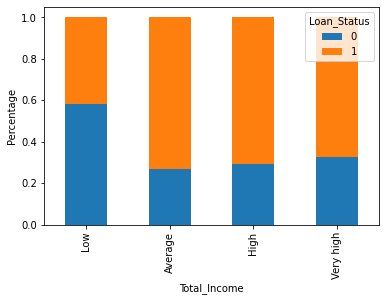

In [115]:
#Let us combine the Applicant Income and Coapplicant Income and see the combined effect of Total Income on the Loan_Status.
Xtrain['Total_Income'] = Xtrain['ApplicantIncome'] + Xtrain['CoapplicantIncome']
bins=[0,2500,4000,6000,81000] 
group=['Low','Average','High', 'Very high'] 
Xtrain['Total_Income_bin']=pd.cut(Xtrain['Total_Income'],bins,labels=group)
Total_Income_bin = pd.crosstab(Xtrain['Total_Income_bin'],Ytrain)
Total_Income_bin.div(Total_Income_bin.sum(axis=1).astype(float), axis=0).plot(kind="bar", stacked=True)  
plt.xlabel('Total_Income') 
plt.ylabel('Percentage')
plt.show()

We can see that Proportion of loans getting approved for applicants having low Total_Income is very less as compared to that of applicants with Average, High and Very High Income.

Loan amount vs Loan status

Text(0, 0.5, 'Percentage')

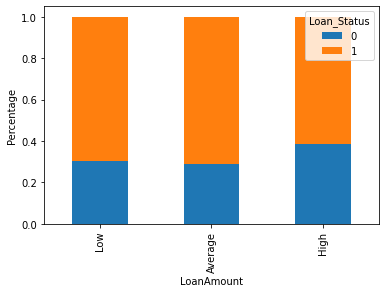

In [116]:
bins=[0,100,200,700] 
group=['Low','Average','High'] 
Xtrain['LoanAmount_bin']=pd.cut(Xtrain['LoanAmount'],bins,labels=group)
LoanAmount_bin=pd.crosstab(Xtrain['LoanAmount_bin'],Ytrain)
LoanAmount_bin.div(LoanAmount_bin.sum(axis=1).astype(float), axis=0).plot(kind="bar", stacked=True) 
plt.xlabel('LoanAmount') 
plt.ylabel('Percentage')

It can be seen that the proportion of approved loans is higher for Low and Average Loan Amount as compared to that of High Loan Amount.

In [0]:
Xtrain = Xtrain.drop(['Income_bin', 'Coapplicant_Income_bin', 'LoanAmount_bin', 'Total_Income_bin', 'Total_Income'], axis=1)

In [0]:
#Change the 3+ in dependents variable to 3 to make it a numerical variable.
Xtrain['Dependents'].replace('3+', 3, inplace=True)
test['Dependents'].replace('3+', 3, inplace=True)

In [0]:
Xtrain['Dependents'] = Xtrain['Dependents'].astype(float)
test['Dependents'] = test['Dependents'].astype(float)

#####Correlation between numeric variables

In [0]:
#lets look at the correlation between all the numerical variables.

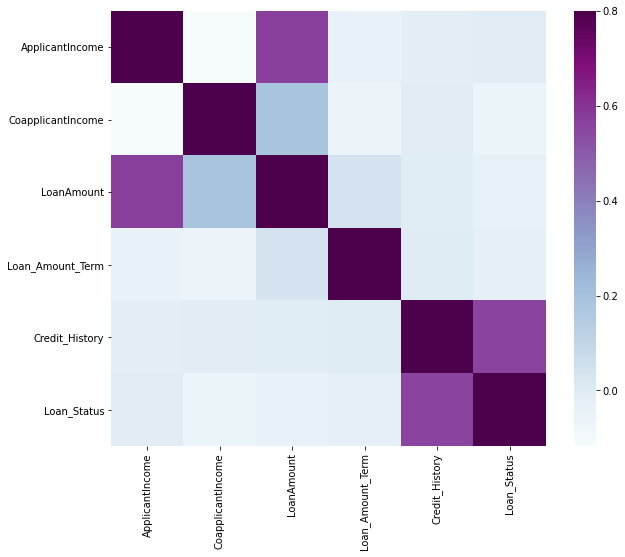

In [121]:
matrix = data.corr()
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(matrix, vmax=0.8, square=True, cmap="BuPu")
plt.show()

We see that the most correlated variables are (ApplicantIncome - LoanAmount) and (Credit_History - Loan_Status). LoanAmount is also correlated with CoapplicantIncome.

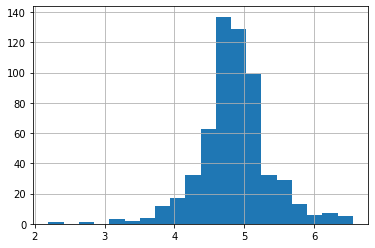

In [122]:
#Log transformation to tackle the skewness feature distribution
Xtrain['LoanAmount'] = np.log(Xtrain['LoanAmount'])
test['LoanAmount'] = np.log(test['LoanAmount'])
Xtrain['LoanAmount'].hist(bins=20)
plt.show()


Now the distribution looks much closer to normal and effect of extreme values has been significantly subsided. 

##Model building

####Missing Data Imputation

In [123]:
#numerical
Xtrain.select_dtypes(exclude='O').isnull().mean()

Dependents           0.024430
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           0.035831
Loan_Amount_Term     0.022801
Credit_History       0.081433
dtype: float64

In [124]:
#categorical
Xtrain.select_dtypes(include='O').isnull().mean()

Gender           0.021173
Married          0.004886
Education        0.000000
Self_Employed    0.052117
Property_Area    0.000000
dtype: float64

In [0]:
#make a list of variable types

#numerical:
numerical = [var for var in Xtrain.columns if Xtrain[var].dtype != 'O']
#categorical
categorical = [var for var in Xtrain.columns if data[var].dtype == 'O']

In [0]:
Xcols = Xtrain.columns

In [0]:
#defining preprocessor
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent', fill_value = 'missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('numerical', numeric_transformer, numerical),
                                               ('categorical', categorical_transformer, categorical)])

In [0]:
#Apply preprocessing pipeline
preprocess = Pipeline(steps=[('preprocessor', preprocessor)])

#fit the pipeline
Xtrain = preprocess.fit_transform(Xtrain)
Xtest = preprocess.fit_transform(test.drop(['Loan_ID'], axis=1))
Ytrain = Ytrain.values

In [129]:
#Model building- Logistic Regression

#Logistic regression
clf = LogisticRegression()
scores = cross_val_score(clf, Xtrain, Ytrain, cv=10, scoring='accuracy')
print(f'Mean score over 10 cross-validation sets: {scores.mean()}')

#test set
clf.fit(Xtrain, Ytrain)
test_predictions = clf.predict(Xtest)
submission = pd.read_csv('sample_submission_49d68Cx.csv')
submission['Loan_Status'] = ['Y' if x == 1 else 'N' for x in test_predictions]
submission['Loan_ID'] = test['Loan_ID']
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('logistic.csv', index=False)

Mean score over 10 cross-validation sets: 0.8095716552088842


In [130]:
#Model building- RandomForest

#RandomForest
clf = RandomForestClassifier(n_estimators=1000)
scores = cross_val_score(clf, Xtrain, Ytrain, cv=10, scoring='accuracy')
print(f'\nmean score over 10 cross-validation sets: {scores.mean()}\n')

#test set
clf.fit(Xtrain, Ytrain)
test_predictions = clf.predict(Xtest)
submission = pd.read_csv('sample_submission_49d68Cx.csv')
submission['Loan_Status'] = ['Y' if x == 1 else 'N' for x in test_predictions]
submission['Loan_ID'] = test['Loan_ID']
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('randomforest.csv', index=False)


mean score over 10 cross-validation sets: 0.7818085668958223



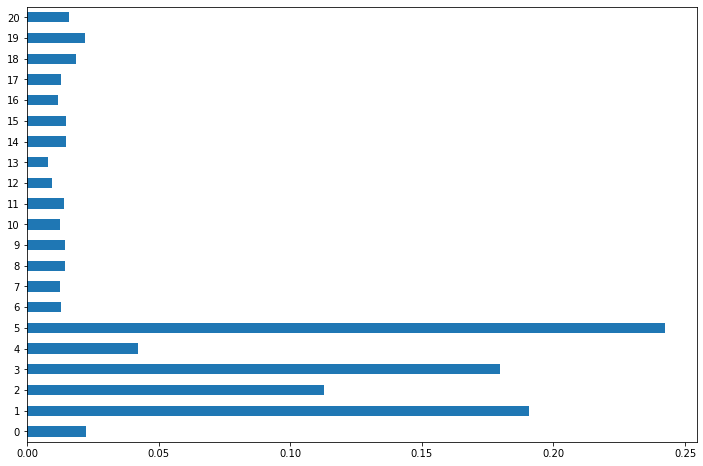

In [131]:
importance = pd.Series(clf.feature_importances_)
importance.plot(kind='barh', figsize=(12,8))
plt.show()

In [132]:
#Model building- XGBoost

#XGBoost
clf = XGBClassifier()
scores = cross_val_score(clf, Xtrain, Ytrain, cv=10, scoring='accuracy')
print(f'\nmean score over 10 cross-validation sets: {scores.mean()}\n')

#test set
clf.fit(Xtrain, Ytrain)
test_predictions = clf.predict(Xtest)
submission = pd.read_csv('sample_submission_49d68Cx.csv')
submission['Loan_Status'] = ['Y' if x == 1 else 'N' for x in test_predictions]
submission['Loan_ID'] = test['Loan_ID']
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('xgboost.csv', index=False)


mean score over 10 cross-validation sets: 0.78841882601798



In [0]:
'''
##Attempt-3 Grid Search, XGBoost

#Preprocessing pipeline for numeric and categorical data 

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value = 'missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, continuous+discrete),
        ('categorical', categorical_transformer, categorical)
    ]
)

#Append classifier to the preprocessing pipeline
#clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(n_estimators=10000, verbose=True))])
clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', XGBClassifier())])

param_grid = {
    'preprocessor__numerical__imputer__strategy': ['mean', 'median'],
    'preprocessor__categorical__imputer__strategy': ['most_frequent', 'constant']
    
}

grid_search = GridSearchCV(clf, param_grid, cv=5, iid=False, n_jobs=-1, scoring='roc_auc')

# and now we train over all the possible combinations of the parameters above
grid_search.fit(Xtrain, Ytrain) 

# and finally let's check the performance over the test set
print(("best classifier from grid search: %.3f" % grid_search.score(Xtest, Ytest)))

# and find the best fit parameters like this
grid_search.best_params_

#Yval = grid_search.predict(Xval.drop('Loan_ID', axis=1))
'''

#Feature Engineering

Based on the domain knowledge, we can come up with new features that might affect the target variable. We will create the following three new features:

Total Income - As discussed during bivariate analysis we will combine the Applicant Income and Coapplicant Income. If the total income is high, chances of loan approval might also be high.
EMI - EMI is the monthly amount to be paid by the applicant to repay the loan. Idea behind making this variable is that people who have high EMI’s might find it difficult to pay back the loan. We can calculate the EMI by taking the ratio of loan amount with respect to loan amount term.
Balance Income - This is the income left after the EMI has been paid. Idea behind creating this variable is that if this value is high, the chances are high that a person will repay the loan and hence increasing the chances of loan approval.

In [0]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
Xtrain2 = data.drop(['Loan_ID','Loan_Status'], axis=1).copy()
Xtest2 = test.drop(['Loan_ID'], axis=1).copy()
Ytrain2 = data['Loan_Status'].copy()     

In [0]:
Xtrain2.columns, Xtest2.columns

In [0]:
#create new feature -  Total_Income
Xtrain2['Total_Income'] = Xtrain2['ApplicantIncome'] + Xtrain2['CoapplicantIncome']
Xtest2['Total_Income'] = Xtest2['ApplicantIncome'] + Xtest2['CoapplicantIncome']

In [0]:
#visualize - Total_Income
sns.distplot(Xtrain2['Total_Income'])

In [0]:
#log-transformation
Xtrain2['Total_Income'] = np.log(Xtrain2['Total_Income'])
Xtest2['Total_Income'] = np.log(Xtest2['Total_Income'])

In [0]:
#visualize after log-transformation
sns.distplot(Xtrain2['Total_Income'])

Now the distribution looks much closer to normal and effect of extreme values has been significantly subsided. 

In [0]:
#create new feature -  EMI
Xtrain2['EMI'] =  (Xtrain2['LoanAmount']) / (Xtrain2['Loan_Amount_Term'])
Xtest2['EMI'] =  (Xtest2['LoanAmount']) / (Xtest2['Loan_Amount_Term'])

In [0]:
#Visualize EMI
sns.distplot(Xtrain2['EMI'])

In [0]:
#log-transformation
Xtrain2['EMI'] = np.log(Xtrain2['EMI'])
Xtest2['EMI'] = np.log(Xtest2['EMI'])

In [0]:
#visualize after log-transformation
sns.distplot(Xtrain2['EMI'])

The distribution looks much closer to normal and effect of extreme values has been significantly subsided.

In [0]:
#create new feature - Balance_Income
Xtrain2['Balance_Income'] = Xtrain2['Total_Income'] - (Xtrain2['EMI']*1000) #Multiply with 1000 to make units equal
Xtest2['Balance_Income'] = Xtest2['Total_Income'] - (Xtest2['EMI']*1000)

In [0]:
#visualize Balance_Income
sns.distplot(Xtrain2['Balance_Income'])

Let us now drop the variables which we used to create these new features. Reason for doing this is, the correlation between those old features and these new features will be very high and logistic regression assumes that the variables are not highly correlated. We also wants to remove the noise from the dataset, so removing correlated features will help in reducing the noise too.

In [0]:
#Drop the previous features used to make new features, to reduce feature correlation
Xtrain2 = Xtrain2.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1) 
Xtest2 = Xtest2.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1)

In [0]:
#make a list of variable types

#numerical:
numerical = [var for var in Xtrain2.columns if Xtrain2[var].dtype != 'O']
#categorical
categorical = [var for var in Xtrain2.columns if Xtrain2[var].dtype == 'O']

In [0]:
#defining preprocessor
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent', fill_value = 'missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('numerical', numeric_transformer, numerical),
                                               ('categorical', categorical_transformer, categorical)])

In [0]:
#Apply preprocessing pipeline
preprocess = Pipeline(steps=[('preprocessor', preprocessor)])

#fit the pipeline
Xtrain2 = preprocess.fit_transform(Xtrain2)
Xtest2 = preprocess.fit_transform(Xtest2)
Ytrain2 = Ytrain2.values

In [0]:
#Model building- Logistic Regression

#Logistic regression
clf = LogisticRegression()
scores = cross_val_score(clf, Xtrain2, Ytrain2, cv=10, scoring='accuracy')
print(f'Mean score over 10 cross-validation sets: {scores.mean()}')

#test set
clf.fit(Xtrain2, Ytrain2)
test_predictions = clf.predict(Xtest2)
submission = pd.read_csv('sample_submission_49d68Cx.csv')
submission['Loan_Status'] = ['Y' if x == 1 else 'N' for x in test_predictions]
submission['Loan_ID'] = test['Loan_ID']
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('logistic2.csv', index=False)

In [0]:
#Model building- RandomForest

#RandomForest
clf = RandomForestClassifier(n_estimators=1000)
scores = cross_val_score(clf, Xtrain2, Ytrain2, cv=10, scoring='accuracy')
print(f'\nmean score over 10 cross-validation sets: {scores.mean()}\n')

#test set
clf.fit(Xtrain2, Ytrain2)
test_predictions = clf.predict(Xtest2)
submission = pd.read_csv('sample_submission_49d68Cx.csv')
submission['Loan_Status'] = ['Y' if x == 1 else 'N' for x in test_predictions]
submission['Loan_ID'] = test['Loan_ID']
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('randomforest2.csv', index=False)